In [ ]:
!pip install natsort

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import time
import torch
import copy, re
import natsort
from PIL import Image
import pandas as pd
from collections import Counter
from tqdm.notebook import trange, tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
# from easyfsl.samplers import TaskSampler
# from easyfsl.utils import plot_images, sliding_average
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from scipy.special import softmax


In [3]:
class Human_Wound_Dataset(Dataset):
    def __init__(self, root_dir, idx_maps_path, seq_len, phase, transform=None):
        self.root_dir = root_dir
        self.transform = transform 
        self.sequence_length = seq_len
        self.end_day = seq_len+1
        self.phase = phase
        self.idx_maps = pd.read_csv(idx_maps_path)
        # self.labels_csv = pd.read_csv('/content/gdrive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/Human_Labels_Final.csv')
        self.samples, self.targets = self.make_dataset(self.root_dir)
        print(self.samples, self.targets)
        # print(len(self.samples))
        self.make_dataset(self.root_dir)
   
    def make_dataset(self, root_dir):
        image_sequence = []
        image_name = []
        image_one_hot = []
        for image_root, image_dirs, image_files in os.walk(self.root_dir, topdown=False):
            image_dirs.sort()
            for image_dirname in image_dirs:
                image_sub_path = os.path.join(image_root, image_dirname)
                image_patient_list = natsort.natsorted(os.listdir(image_sub_path))
                
                # if len(image_patient_list) < self.sequence_length:
                #     continue

                patientwise_list = []
                patient_name_list = []
                patient_counter = 0

                # while patient_counter < self.sequence_length:
                for patient_image in image_patient_list:
                    patient_name_list.append(patient_image)
                    image_patient_id,image_day, image_patient_class = patient_image.split('_')
                    image_paths = os.path.join(image_root, image_dirname + '/' +image_patient_list[patient_counter])
                    patientwise_list.append(image_paths)
                    patient_counter += 1
                # print(patientwise_list)
                image_sequence.append(patientwise_list)
                image_name.append(patient_name_list)
                if image_patient_class[:-4] == 'Healer':
                    image_one_hot.append(1)
                else:
                    image_one_hot.append(0)

        return image_sequence, image_name
        

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
        """
        Returns tensor data and label.
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where sample is a tensor of input data
                    target is class of sample.
        """
        # Get images and targets, drop alpha
        loaded_img_list = []
        img_seg = self.samples[index]
        img_seq_indx = []
        total_image_matching_Sequence = []

        for img_path in img_seg:
            img = self.pil_loader(img_path)
            loaded_img_list.append(img)
            lst = []
            image_matching_sequence = []

            if self.phase == 'query_set':
                image_name = os.path.basename(img_path)
                lst = self.idx_maps.loc[self.idx_maps['Name'] == image_name].values.flatten().tolist()[1:]
                
            total_image_matching_Sequence.append(lst)

        final_list = []
        if self.transform:
            for img in loaded_img_list:
                img = self.transform(img)
                final_list.append(img)            

        stacked_final = torch.stack(final_list)

        target = self.targets[index]

        return stacked_final, target
        # return stacked_final

    def __len__(self):
        return len(self.samples)

In [4]:
human = Human_Wound_Dataset('/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/', '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/support_idx_maps.csv', 3, 'support_set')

[['/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/BAART046/BAART046_0_NonHealer.png', '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/BAART046/BAART046_7_NonHealer.png', '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/BAART046/BAART046_14_NonHealer.png', '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/BAART046/BAART046_21_NonHealer.png', '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/BAART046/BAART046_28_NonHealer.png', '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/BAART046/BAART046_35_NonHealer.png', '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/BAART046/BAART046_42_NonHealer.png', '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/support_set/BAART046/BAART046_49_NonHealer.png', '/content/drive/

In [5]:
def wound_collate(batch):
    # Form a tensor of first tuple items in batch
    data = torch.stack([item[0] for item in batch])  
    # Tensorize targets
    target = [item[1] for item in batch]
    # target = torch.LongTensor(target)
    # Return tuple of data & targets
    return [data, target]

In [6]:
def wound_dataloader(dataset, batch_size: int, num_workers = 0, shuffle = False, pin_memory = False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=wound_collate,
        num_workers=num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory)

In [7]:
input_size = (224,244) # Muse be 224 (3x224x224) for Densenet121

# Standard Pytorch image transforms (source:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
data_transforms = {
    'support_set': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'query_set': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
class Encoder(nn.Module):
    """
    Encoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(Encoder, self).__init__() 
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])
        # 7x7 average pool layer
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        # Left image connected layers
        self.fc_16 = nn.Linear(1024, 16)

    def forward(self, x):
        # Embed image
        u1 = self.embed_model(x.cuda())
        u1 = self.avg(u1)
        u1 = u1.view(-1,1024)
        u1 = self.fc_16(u1)
        return u1

    def load_embed_wts(self, device):
        """
        load pretrained model weights, use only when transfer learning from ImageNET data
        """
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)

        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])


class FewShotNet(nn.Module):
    """
    HealNet model Pytorch. 
    """
    def __init__(self, seq_len):
        # Initialize self._modules as OrderedDict
        super(FewShotNet, self).__init__() 
        self.encoder = Encoder()
        self.sequence_length = seq_len

    def load_encoder_wts(self,device):
        """
        load pretrained model weights, use only when transfer learning from ImageNET data
        """
        # Initialize densenet121
        self.encoder.load_embed_wts(device)

    def forward(self, x):
        feature_list = []
        sq_len = x.shape[1]
        for i in range(sq_len):
            
            ftr = self.encoder(x[:,i,:,:,:].cpu())
            feature_list.append(ftr)
        stacked = torch.stack(feature_list)

        return stacked


In [9]:
def few_shot_classifier(model, dataloader, sequence_length, idx_maps_path):
    idx_maps = pd.read_csv(idx_maps_path)
    support_set_length = len(dataloader['support_set'])
    query_set_length = len(dataloader['query_set'])
    model.eval()
    
    support_encodings = []
    support_labels = []
    query_encodings = []
    query_labels = []
    Total_query_image_matching_sqeuence = []
    y_support = []
    y_query = []

    for shot, shot_label in dataloader['support_set']:
        seq_len = shot.shape[1]
        shot_ftr = model(shot).cpu().detach().numpy().reshape(seq_len, 16)
        support_encodings.append(shot_ftr)
        support_labels.extend(shot_label)

    for names in support_labels:
        support_class = names[0].split('_')[2][:-4]
        if support_class == 'NonHealer':
            y_support.append(0)
        else:
            y_support.append(1)

    for query, query_label in dataloader['query_set']:
        seq_len = query.shape[1]
        query_ftr = model(query).cpu().detach().numpy().reshape(seq_len, 16)
        query_encodings.append(query_ftr)
        query_labels.extend(query_label)
        del query_ftr

    for names in query_labels:
        query_class = names[0].split('_')[2][:-4]
        if query_class == 'NonHealer':
            y_query.append(0)
        else:
            y_query.append(1)

    y_pred = []

    for i,query_sequence in enumerate(query_encodings):
        if query_sequence.shape[0] < sequence_length:
            y_query.pop(i)
            continue

        query_image_counter = 0
        query_sequence_predicted_class_list = []
        min_distance_list = []

        while query_image_counter < sequence_length:
                
            query_image_ftr = query_sequence[query_image_counter]
            lst = idx_maps.loc[idx_maps['Name'] == query_labels[i][query_image_counter]].values.flatten().tolist()[1:]
            
            distance_list = []
            
            for k, support_image_ftr in enumerate(support_encodings):
                curr_support_vector = support_image_ftr[lst[k]]
                euc_dist = np.linalg.norm(curr_support_vector - query_image_ftr)
                distance_list.append(euc_dist)

            min_idx = np.argmin(distance_list)
            current_query_predicted_class = y_support[min_idx]
            min_distance_list.append(min(distance_list))
            query_sequence_predicted_class_list.append(current_query_predicted_class)
            query_image_counter += 1

        if sequence_length%2 == 0 and (query_sequence_predicted_class_list.count(1) == query_sequence_predicted_class_list.count(0)):
            total_min_idx = np.argmin(np.array(min_distance_list))
            final_query_sequence_prediction = query_sequence_predicted_class_list[total_min_idx]
        else:
            final_query_sequence_prediction = max(query_sequence_predicted_class_list, key = query_sequence_predicted_class_list.count)

        y_pred.append(final_query_sequence_prediction)

    return y_query, y_pred

In [10]:
sequence_length = 6
fewshot = FewShotNet(sequence_length)
fewshot.to(device)

# fewshot.load_encoder_wts(device)
# path_to_encoder = '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/meta_learned_ENCODER.tar'
# path_to_encoder = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/June2_I_U->O_C.tar_ENCODER.tar" # Path to healnet weights
path_to_encoder = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/only_O_C_ENCODER.tar"
# path_to_encoder = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/Contrastive_Encoder_June_20_n_4"

fewshot.encoder.load_state_dict(torch.load(path_to_encoder, map_location=torch.device(device)))
data_path = '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/Dataset/'
idx_mps_path = '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/support_idx_maps.csv'
batch_size = 1
data_loaders_dict = {phase: wound_dataloader(Human_Wound_Dataset(data_path+phase, idx_mps_path, sequence_length, phase, transform=data_transforms[phase]), 
                                             batch_size, num_workers = 0, shuffle = False, pin_memory = True) for phase in ['support_set', 'query_set']}

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


RuntimeError: ignored

In [ ]:
len(data_loaders_dict['query_set'])

15

In [ ]:
torch.cuda.empty_cache()

In [ ]:
y_tests, y_preds = few_shot_classifier(fewshot, data_loaders_dict, sequence_length, idx_mps_path)

In [ ]:
print("SEQUENCE LENGTH: " + str(sequence_length))
print("ACCURACY:" + str(accuracy_score(y_tests, y_preds)))
print(classification_report(y_tests, y_preds))

SEQUENCE LENGTH: 6
ACCURACY:0.8
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.71      0.83         7

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10



In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(fewshot)

+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|              encoder.embed_model.0.conv0.weight             |    9408    |
|              encoder.embed_model.0.norm0.weight             |     64     |
|               encoder.embed_model.0.norm0.bias              |     64     |
|  encoder.embed_model.0.denseblock1.denselayer1.norm1.weight |     64     |
|   encoder.embed_model.0.denseblock1.denselayer1.norm1.bias  |     64     |
|  encoder.embed_model.0.denseblock1.denselayer1.conv1.weight |    8192    |
|  encoder.embed_model.0.denseblock1.denselayer1.norm2.weight |    128     |
|   encoder.embed_model.0.denseblock1.denselayer1.norm2.bias  |    128     |
|  encoder.embed_model.0.denseblock1.denselayer1.conv2.weight |   36864    |
|  encoder.embed_model.0.denseblock1.denselayer2.norm1.weight |     96     |

6970256

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
precision, recall, fscore, support = score(y_tests, y_preds)
accuracy = accuracy_score(y_tests, y_preds)

print(accuracy)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

0.6923076923076923
precision: [0.5        0.77777778]
recall: [0.5        0.77777778]
fscore: [0.5        0.77777778]
support: [4 9]


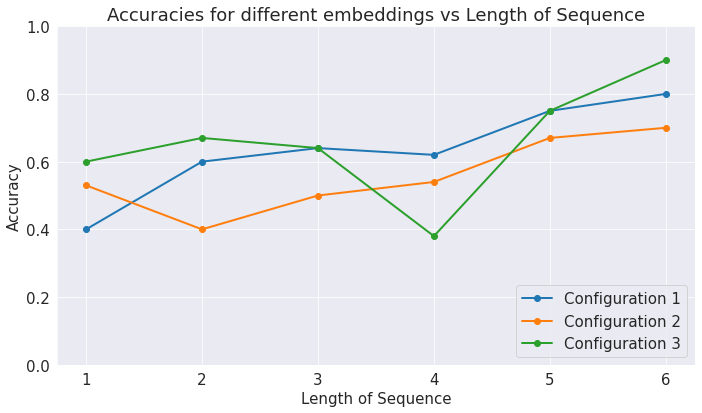

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes

acc_I_O = [0.4, 0.6, 0.64, 0.62, 0.75, 0.8]
acc_O_I = [0.53, 0.4, 0.5, 0.54, 0.67, 0.7]
acc_O = [0.6, 0.67, 0.64, 0.38, 0.75, 0.9]
# prec = [ 0.62, 0.62, 0.71, 0.69, 0.86, 0.80]
# rec = [ 0.42857, 0.42857, 0.71428, 0.69230, 0.83334, 0.8]
# F1 = [ 0.42857, 0.42857, 0.71428, 0.69230, 0.83334, 0.8]

sns.set_style('darkgrid')
plt.figure(figsize=(10,6), tight_layout=True)
#plotting
plt.plot(acc_I_O, 'o-', linewidth=2)
plt.plot(acc_O_I, 'o-', linewidth=2)
plt.plot(acc_O, 'o-', linewidth=2)
#customization
plt.ylim(0, 1.0)

plt.xticks(np.arange(len(acc_I_O)), np.arange(1, len(acc_I_O)+1))
plt.ylabel('Accuracy')
plt.xlabel('Length of Sequence')
plt.title('Accuracies for different embeddings vs Length of Sequence')
plt.legend(title_fontsize = 13, labels=['Configuration 1', 'Configuration 2', 'Configuration 3'], loc='lower right')
plt.show()


In [ ]:
        # print(healer_sum/healer_count, healer_count)
        # print(nonhealer_sum/nonhealer_count, nonhealer_count)

        # # if (sequence_length % 2) == 0:
        # for dist_list in seq_dist_list:
        #     healer_sum = 0
        #     heal_count = 0
        #     nonhealer_sum = 0
        #     nonheal_count = 0
        #     for j in range(len(dist_list)):
        #         if support_labels[j] == 1:
        #             healer_sum+=dist_list[j]
        #             heal_count+=1
        #         else:
        #             nonhealer_sum+=dist_list[j]
        #             nonheal_count+=1
        # print(healer_sum, heal_count)
        # print(nonhealer_sum, nonheal_count)
        # if (healer_sum/heal_count > nonhealer_sum/nonheal_count):
        #     print("Nonhealer "+str(0))
        #     y_pred = 0
        # elif (healer_sum/heal_count < nonhealer_sum/nonheal_count):
        #     print("healer "+str(1))
        #     y_pred = 1
        # print("y pred is: ", y_pred)
        # y_pred_list.append(y_pred)